In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import time
import os
import sys
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import bias
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import linear_theory
import tools

### load galaxies

In [3]:
# main inputs
snapshots = np.arange(41, 60).astype(int) # np.arange(63, 73) to center at z=0.5
sigma_z = 0.1  # one of the 5 redshift error bins in SPHEREx

In [4]:
# there is a jump in SPHEREx galaxy number density around z=1; we want to interpolate this

# first get the target number densities
redshifts = np.empty(len(snapshots))
target_ns = np.empty(len(snapshots))
for i, snapshot in enumerate(snapshots):
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    redshifts[i] = sim.redshift
    target_ns[i] = sim.survey_params('SPHEREx', '', sigma_z).n_Mpc3 # * (u.littleh / u.Mpc)**3
target_ns *= (u.littleh / u.Mpc)**3 # return units

target_ns_interp = tools.interpolate_number_densities(redshifts, target_ns)
mean_n = np.mean(target_ns_interp)

Text(0.5, 1.0, 'Target galaxy number densities with $\\sigma_z=$0.1: interpolation')

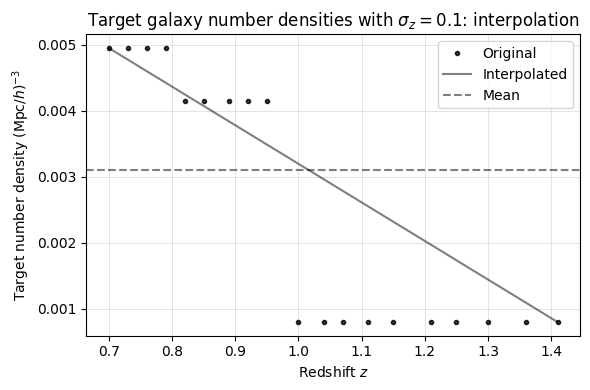

In [5]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, target_ns, 'k.', alpha=0.8, label='Original')
ax.plot(redshifts, target_ns_interp, 'k-', alpha=0.5, label='Interpolated')
ax.axhline(mean_n, c='k', ls='--', alpha=0.5, label='Mean')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Target number density (Mpc/$h)^{-3}$')
ax.legend()
ax.set_title(r'Target galaxy number densities with $\sigma_z=$'f'{sigma_z}: interpolation')

In [6]:
# construct spherex galaxy samples
# fixed galaxy density
data = photxspec.construct_spherex_galaxy_samples(snapshots, sigma_z,
                                                  ns=mean_n * np.ones_like(redshifts)) # !! density
redshifts, chis, gal_pos_specs_n_fixed, boxsize = data['redshifts'], data['chis'], \
                                                    data['gal_pos_specs'], data['boxsize']
    
data = photxspec.construct_spherex_galaxy_samples(snapshots, sigma_z,
                                                  ns=target_ns_interp) # !! density
redshifts, chis, gal_pos_specs_ns_interp, boxsize = data['redshifts'], data['chis'], \
                                                    data['gal_pos_specs'], data['boxsize']

input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
removing 1 values
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
removing 1 values
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
in

### compute bias in each snapshot

In [7]:
# inputs:
rmin = 1
rmax = 100
nbins = 15
periodic = True

In [8]:
# get linear bias from spectroscopic sample
ratios_n_fixed = np.empty((len(redshifts), nbins))
ratios_ns_interp = np.empty_like(ratios_n_fixed)
for i, redshift in enumerate(redshifts):
    print(f'{i+1} of {len(redshifts)} (z={redshift:.2f})', end='\r')
    kwargs = dict(redshift=redshift, boxsize=sim.boxsize, method='auto_gal',
                     rmin=rmin, rmax=rmax, nbins=nbins, periodic=periodic)
    ravg, ratios_n_fixed[i] = linear_theory.get_linear_bias(gal_pos_specs_n_fixed[i], **kwargs)
    ravg, ratios_ns_interp[i] = linear_theory.get_linear_bias(gal_pos_specs_ns_interp[i], **kwargs)

/work/08811/aew492/frontera/small-scale_cross-corrs/linear_theory.py:78: RuntimeWarning: invalid value encountered in sqrt
  ratio = np.sqrt(galxgal / tools.linear_2pcf(redshift, ravg))


In [9]:
# range to compute linear bias
biasrange = [-10,-5] # indices from ravg

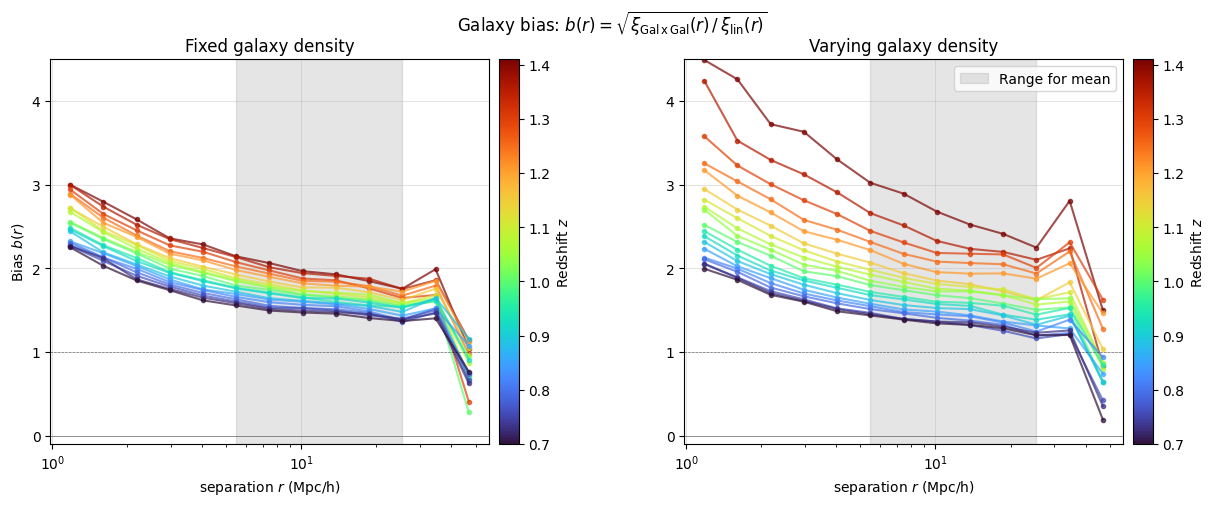

In [10]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15,5))
norm = mpl.colors.Normalize(min(redshifts), max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
for i, redshift in enumerate(redshifts):
    axs[0].plot(ravg, ratios_n_fixed[i], marker='.', ls='-', c=smap.to_rgba(redshift), alpha=0.7)
    axs[1].plot(ravg, ratios_ns_interp[i], marker='.', ls='-', c=smap.to_rgba(redshift), alpha=0.7)
for ax in axs:
    ax.axvspan(ravg[biasrange[0]], ravg[biasrange[1]], color='grey', alpha=0.2, label=f'Range for mean')
    ax.set_ylim(-.1, 4.5)
    ax.axhline(0, c='k', alpha=0.5, lw=0.5)
    ax.axhline(1, c='k', alpha=0.5, lw=0.5, ls='--')
    ax.semilogx()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    fig.colorbar(smap, ax=ax, label=r'Redshift $z$', pad=0.02)
axs[0].set_ylabel(r'Bias $b(r)$')
axs[0].set_title('Fixed galaxy density')
axs[1].set_title('Varying galaxy density')
fig.suptitle(f'Galaxy bias: 'r'$b(r) = \sqrt{\xi_\mathrm{Gal\,x\,Gal}(r)\,/\,\xi_\mathrm{lin}(r)}$')
axs[1].legend()

In [11]:
# mean b(r) in each snapshot, over the range of scales where b(r) is ~ flat
biases_n_fixed = np.array([
    np.mean(ratio[biasrange[0]:biasrange[1]]) for ratio in ratios_n_fixed
])
biases_ns_interp = np.array([
    np.mean(ratio[biasrange[0]:biasrange[1]]) for ratio in ratios_ns_interp
])

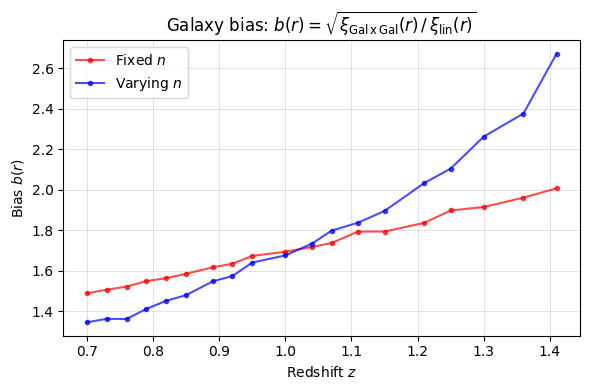

In [12]:
# plot
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, biases_n_fixed, 'r.-', alpha=0.7, label=r'Fixed $n$')
ax.plot(redshifts, biases_ns_interp, 'b.-', alpha=0.7, label=r'Varying $n$')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Bias $b(r)$')
ax.set_title(f'Galaxy bias: 'r'$b(r) = \sqrt{\xi_\mathrm{Gal\,x\,Gal}(r)\,/\,\xi_\mathrm{lin}(r)}$')
ax.legend()

In [13]:
# save
save_fn = f'/scratch1/08811/aew492/TNG300-3/bias/bias_z-{min(redshifts):.2f}-{max(redshifts):.2f}_sigmaz-{sigma_z}'
save_dict = dict(sigma_z=sigma_z, redshifts=redshifts, biases=biases_n_fixed, ns=mean_n * np.ones_like(redshifts))
np.save(save_fn+f'_n_fixed.npy', save_dict)
save_dict = dict(sigma_z=sigma_z, redshifts=redshifts, biases=biases_ns_interp, ns=target_ns_interp)
np.save(save_fn+f'_ns_interp.npy', save_dict)

#### galaxy masses

In [14]:
# galaxy masses for both constant and interpolated number densities
M_n_fixed = []
M_ns_interp = []
for i, snapshot in enumerate(snapshots):
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    M_n_fixed.append(sim.subhalo_mass()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, n=mean_n)])
    M_ns_interp.append(sim.subhalo_mass()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, n=target_ns_interp[i])])
# mean and standard deviation in each snapshot
mean_M_n_fixed = np.array([np.mean(x.value) for x in M_n_fixed])
std_M_n_fixed = np.array([np.std(x.value) for x in M_n_fixed])
mean_M_ns_interp = np.array([np.mean(x.value) for x in M_ns_interp])
std_M_ns_interp = np.array([np.std(x.value) for x in M_ns_interp])

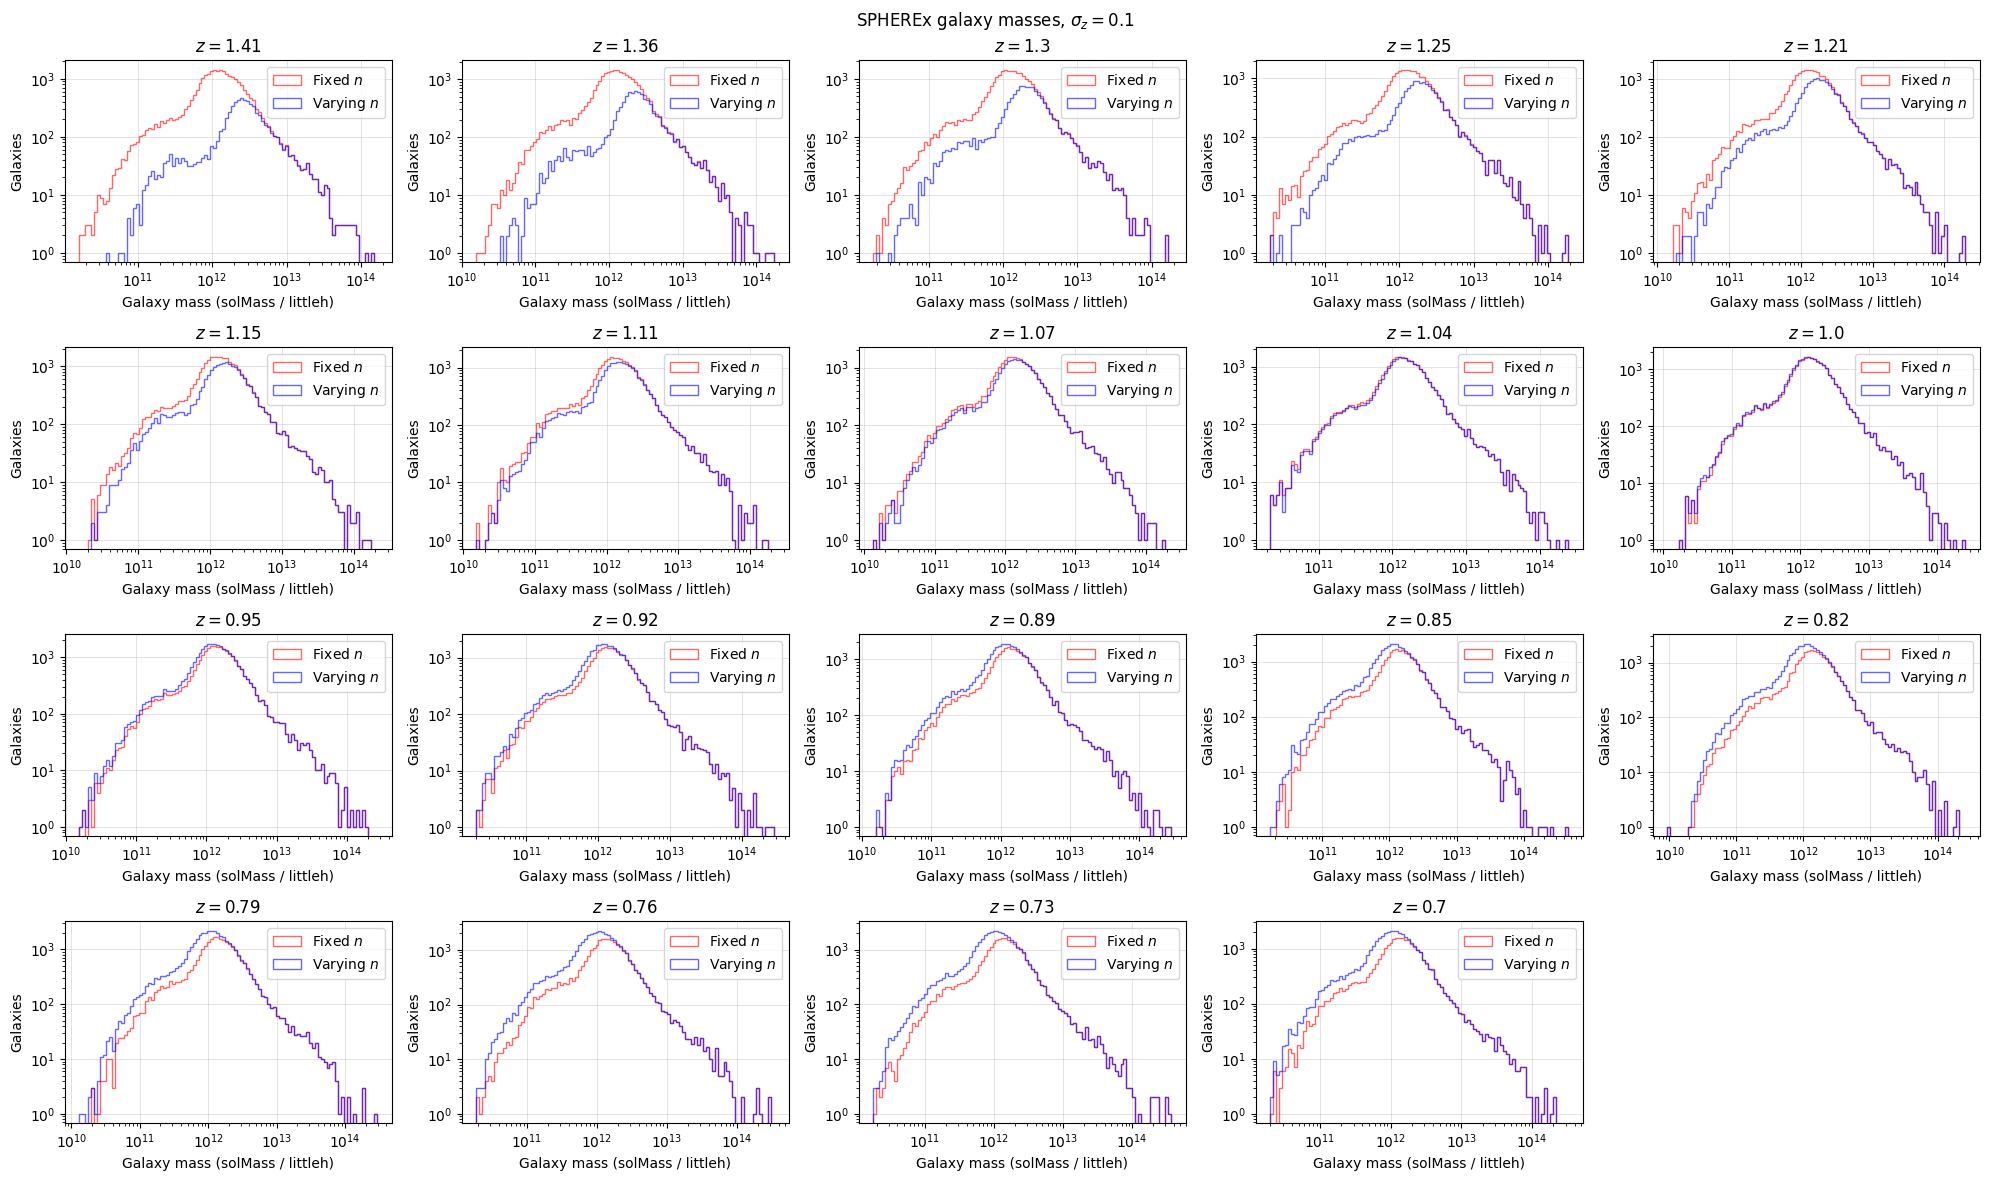

In [15]:
# some histograms
fig = plt.figure(figsize=(20,12))
for i, redshift in enumerate(redshifts):
    ax = fig.add_subplot(4, 5, i+1)
    bins = np.logspace(np.log10(np.amin(np.concatenate([M_n_fixed[i].value, M_ns_interp[i].value]))),
                       np.log10(np.amax(np.concatenate([M_n_fixed[i].value, M_ns_interp[i].value]))), 101)
    kwargs = dict(bins=bins, histtype='step', alpha=0.6)
    _, _, _ = ax.hist(M_n_fixed[i].value, color='r', label=r'Fixed $n$', **kwargs)
    _, _, _ = ax.hist(M_ns_interp[i].value, color='b', label=r'Varying $n$', **kwargs)
    ax.grid(alpha=0.5, lw=0.5)
    ax.loglog()
    ax.set_xlabel(f'Galaxy mass ({M_n_fixed[i].unit})')
    ax.set_ylabel(f'Galaxies')
    ax.set_title(r'$z=$'f'{redshifts[i]}')
    ax.legend()
fig.suptitle(r'SPHEREx galaxy masses, $\sigma_z=$'f'{sigma_z}')
fig.tight_layout()

Text(0.5, 1.0, 'Mean SPHEREx galaxy masses, $\\sigma_z=$0.1')

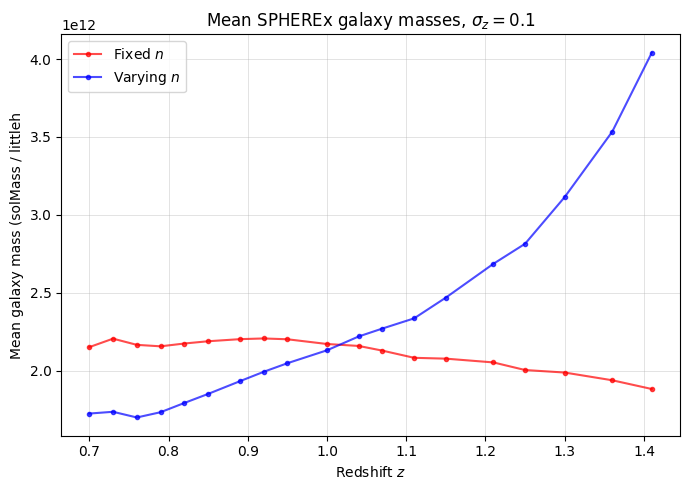

In [16]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(alpha=0.7, marker='.')
ax.plot(redshifts, mean_M_n_fixed, c='r', label=r'Fixed $n$', **kwargs)
ax.plot(redshifts, mean_M_ns_interp, c='b', label=r'Varying $n$', **kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(f'Mean galaxy mass ({M_n_fixed[0].unit}')
ax.legend()
ax.set_title(r'Mean SPHEREx galaxy masses, $\sigma_z=$'f'{sigma_z}')

### bias-halo-mass function

In [27]:
print(M_n_fixed[0].unit)

solMass / littleh


In [29]:
# from Colossus: scale-free bias model: bias is only a function of halo mass and redshift
# get the bias of each halo, then save the mean of all halos in each snapshot
mean_modelbias_n_fixed = np.empty(len(redshifts))
mean_modelbias_ns_interp = np.empty(len(redshifts))
for i, redshift in enumerate(redshifts):
    modelbias_n_fixed = bias.haloBias(M_n_fixed[i].to(u.solMass / u.littleh).value, redshift,
                                      mdef='fof', model='sheth01') # Sheth et al. 2001
    modelbias_ns_interp = bias.haloBias(M_ns_interp[i].to(u.solMass / u.littleh).value, redshift,
                                      mdef='fof', model='sheth01')
    # save means
    assert np.sum(np.isnan(modelbias_n_fixed)) == np.sum(np.isnan(modelbias_ns_interp)) == 0
    mean_modelbias_n_fixed[i] = np.mean(modelbias_n_fixed)
    mean_modelbias_ns_interp[i] = np.mean(modelbias_ns_interp)

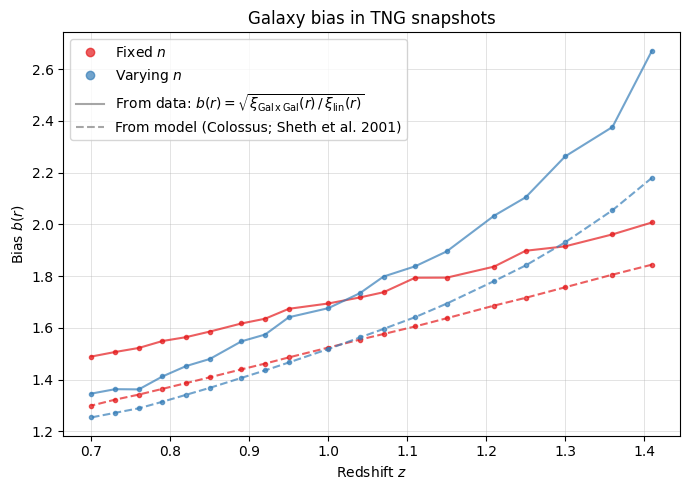

In [37]:
# plot
cs = list(map(mpl.cm.Set1, range(5)))
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(redshifts, biases_n_fixed, c=cs[0], marker='.', alpha=0.7)
ax.plot(redshifts, biases_ns_interp, c=cs[1], marker='.', alpha=0.7)
ax.plot(redshifts, mean_modelbias_n_fixed, c=cs[0], marker='.', ls='--', alpha=0.7)
ax.plot(redshifts, mean_modelbias_ns_interp, c=cs[1], marker='.', ls='--', alpha=0.7)

# manual labels
fixedm = mpl.lines.Line2D([0], [0], marker='o', ls='None', c=cs[0], alpha=0.7, label=r'Fixed $n$')
interpm = mpl.lines.Line2D([0], [0], marker='o', ls='None', c=cs[1], alpha=0.7, label=r'Varying $n$')
dataline = mpl.lines.Line2D([0], [0], marker='None', c='grey', alpha=0.7,
                        label=r'From data: $b(r) = \sqrt{\xi_\mathrm{Gal\,x\,Gal}(r)\,/\,\xi_\mathrm{lin}(r)}$')
modelline = mpl.lines.Line2D([0], [0], marker='None', c='grey', alpha=0.7, ls='--',
                        label=r'From model (Colossus; Sheth et al. 2001)')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([fixedm, interpm, dataline, modelline])

ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Bias $b(r)$')
ax.set_title(f'Galaxy bias in TNG snapshots')
ax.legend(handles=handles)

Text(0.5, 1.0, 'Galaxy bias in TNG snapshots: residuals')

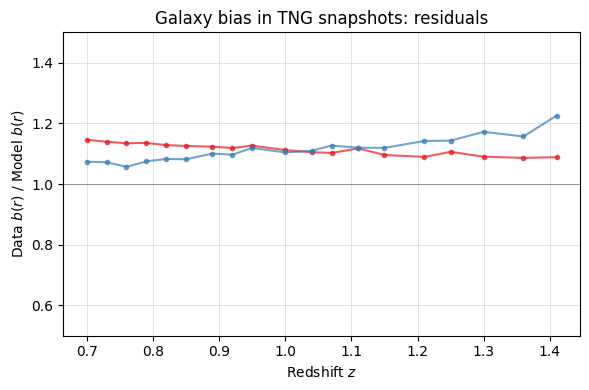

In [43]:
# residuals
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, biases_n_fixed / mean_modelbias_n_fixed, c=cs[0], marker='.', alpha=0.7)
ax.plot(redshifts, biases_ns_interp / mean_modelbias_ns_interp, c=cs[1], marker='.', alpha=0.7)
ax.axhline(1., c='k', lw=0.5, alpha=0.5)
ax.set_ylim(.5, 1.5)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Data $b(r)$ / Model $b(r)$')
ax.set_title(f'Galaxy bias in TNG snapshots: residuals')